In [2]:
# Cell 1: Dataset Verification
import os

def total_files(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Training set
train_files_healthy = "Dataset/Train/Train/Healthy"
train_files_powdery = "Dataset/Train/Train/Powdery"
train_files_rust = "Dataset/Train/Train/Rust"

# Test set
test_files_healthy = "Dataset/Test/Test/Healthy"
test_files_powdery = "Dataset/Test/Test/Powdery"
test_files_rust = "Dataset/Test/Test/Rust"

# Validation set
valid_files_healthy = "Dataset/Validation/Validation/Healthy"
valid_files_powdery = "Dataset/Validation/Validation/Powdery"
valid_files_rust = "Dataset/Validation/Validation/Rust"

print("Training Set:")
print(f"Healthy: {total_files(train_files_healthy)}")
print(f"Powdery: {total_files(train_files_powdery)}")
print(f"Rust: {total_files(train_files_rust)}\n")

print("Test Set:")
print(f"Healthy: {total_files(test_files_healthy)}")
print(f"Powdery: {total_files(test_files_powdery)}")
print(f"Rust: {total_files(test_files_rust)}\n")

print("Validation Set:")
print(f"Healthy: {total_files(valid_files_healthy)}")
print(f"Powdery: {total_files(valid_files_powdery)}")
print(f"Rust: {total_files(valid_files_rust)}")

Training Set:
Healthy: 458
Powdery: 430
Rust: 434

Test Set:
Healthy: 50
Powdery: 50
Rust: 50

Validation Set:
Healthy: 50
Powdery: 70
Rust: 70


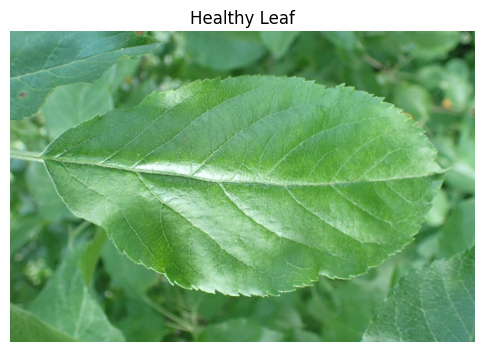

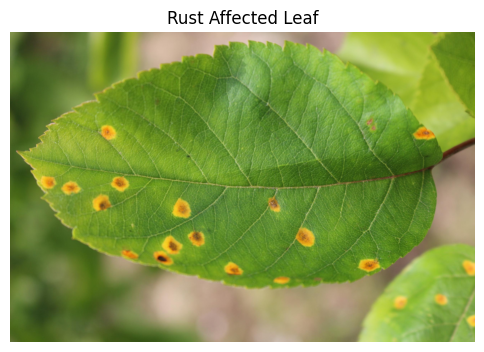

In [3]:
# Cell 2: Sample Image Display
from PIL import Image
import IPython.display as display
import matplotlib.pyplot as plt

def display_image(image_path, title):
    plt.figure(figsize=(6, 6))
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display sample images
display_image('Dataset/Train/Train/Healthy/8ce77048e12f3dd4.jpg', 'Healthy Leaf')
display_image('Dataset/Train/Train/Rust/80f09587dfc7988e.jpg', 'Rust Affected Leaf')

In [4]:
# Cell 3: Data Augmentation & Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    'Dataset/Train/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_test_datagen.flow_from_directory(
    'Dataset/Validation/Validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    'Dataset/Test/Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1322 images belonging to 3 classes.
Found 190 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [5]:
# Cell 4: Model Architecture (Transfer Learning)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf

def create_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze base model
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(3, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    # Unfreeze last 5 layers
    for layer in base_model.layers[-5:]:
        layer.trainable = True
        
    return model

model = create_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape              ┃        Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)         │ (None, 224, 224, 3)       │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ mobilenetv2_1.00_224 (Functional)  │ (None, 7, 7, 1280)        │      2,257,984 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ global_average_pooling2d           │ (None, 1280)              │              0 │
│ (GlobalAveragePooling2D)           │                           │                │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dropout (Dropout)                  │ (None, 1280)              │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dense (Dense)                      │ (None, 256)               │        327,936 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ batch_normalization                │ (None, 256)               │          1,024 │
│ (BatchNormalization)               │                           │                │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dropout_1 (Dropout)                │ (None, 256)               │              0 │
├────────────────────────────────────┼───────────────────────────┼────────────────┤
│ dense_1 (Dense)                    │ (None, 3)                 │            771 │
└────────────────────────────────────┴───────────────────────────┴────────────────┘

 Total params: 2,587,715 (9.87 MB)

 Trainable params: 1,049,219 (4.00 MB)

 Non-trainable params: 1,538,496 (5.87 MB)

In [6]:
# Cell 5: Model Compilation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

optimizer = Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [7]:
# Cell 6: Class Weight Calculation
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Get class weights
class_indices = train_generator.class_indices
class_counts = [total_files(os.path.join('Dataset/Train/Train', cls)) for cls in class_indices.keys()]
class_weights = compute_class_weight('balanced',
                                    classes=np.unique(train_generator.classes),
                                    y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights}")

Class Weights: {0: np.float64(0.9621542940320232), 1: np.float64(1.0248062015503876), 2: np.float64(1.0153609831029187)}


In [8]:
# Cell 7: Model Training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

C:\Users\sarpa\plant_disease_detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7878 - loss: 0.5611 - precision: 0.8007 - recall: 0.7729 - val_accuracy: 0.4789 - val_loss: 4.8631 - val_precision: 0.4789 - val_recall: 0.4789 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9361 - loss: 0.1870 - precision: 0.9382 - recall: 0.9310 - val_accuracy: 0.5526 - val_loss: 8.7107 - val_precision: 0.5526 - val_recall: 0.5526 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9458 - loss: 0.1505 - precision: 0.9496 - recall: 0.9442 - val_accuracy: 0.5105 - val_loss: 14.4367 - val_precision: 0.5105 - val_recall: 0.5105 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9614 - loss: 0.1228 - precision: 0.9677 - recall: 0.9596 - val_accuracy: 0.3895 - val_loss: 15.7510 - val_precision: 0.3895 - val_recall: 0.3895 - learning_rate: 0.0010
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9561 -

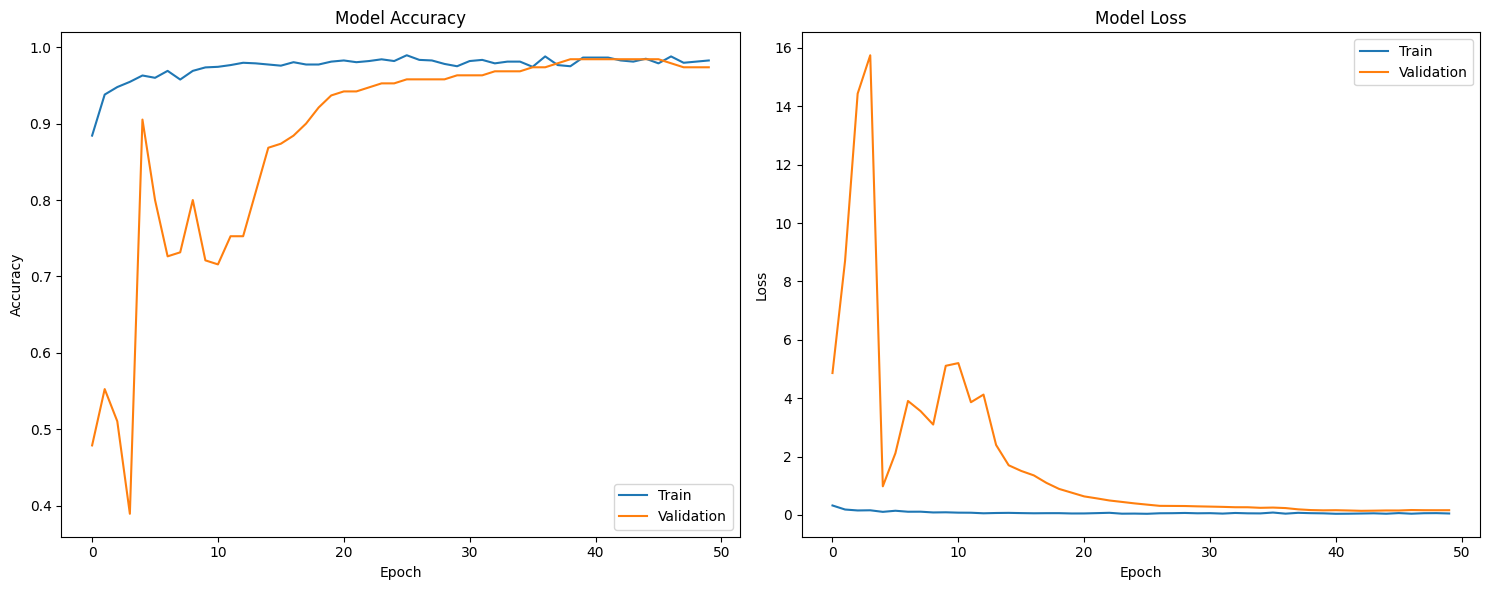

In [9]:
# Cell 8: Training Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\sarpa\plant_disease_detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9807 - loss: 0.1684 - precision: 0.9807 - recall: 0.9807    

Test Accuracy: 98.00%
Test Precision: 98.00%
Test Recall: 98.00%
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step   

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      1.00      0.97        50
     Powdery       1.00      0.94      0.97        50
        Rust       1.00      1.00      1.00        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



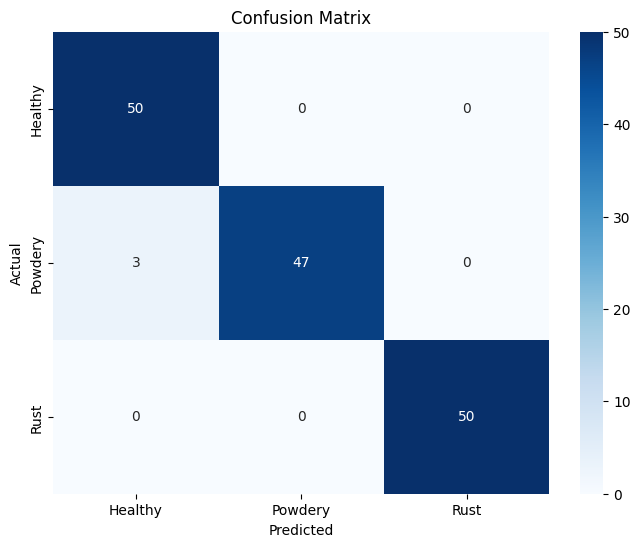

In [11]:
# Cell 9: Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate on test set
test_results = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_results[1]:.2%}")
print(f"Test Precision: {test_results[2]:.2%}")
print(f"Test Recall: {test_results[3]:.2%}")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
class_names = list(test_generator.class_indices.keys())  # Removed extra parenthesis
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


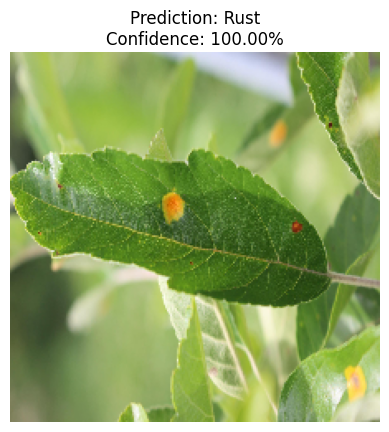

In [12]:
# Cell 10: Model Saving & Prediction Example
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Save model
model.save("leaf_disease_model2.h5")

# Prediction function
def predict_disease(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    confidence = np.max(pred)
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {class_names[class_idx]}\nConfidence: {confidence:.2%}")
    plt.show()

# Test prediction
predict_disease('Dataset/Test/Test/Rust/82f49a4a7b9585f1.jpg')